In [1]:
# import
import warnings
import cv2
import pickle
import math
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import pyautogui as pg

from time import time, sleep
from tqdm import tqdm
from glob import glob
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from threading import Thread
from matplotlib import pyplot as plt
from line_profiler import LineProfiler


class Samples_container:
    imgs_real_part = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/part/*.jpg")
    imgs_color_black = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/black/*.jpg")
    imgs_color_white = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/white/*.jpg")
    imgs_color_green = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/green/*.jpg")
    imgs_color_red = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/red/*.jpg")
    imgs_entire = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/entire/*.jpg")
    imgs_part = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/part/*.jpg")


In [2]:
# initial settings

print("OpenCV", cv2.__version__)
print("numpy", np.__version__)
print("pandas", pd.__version__)
print("Pyautogui", pg.__version__)
print("Scikit-learn", sklearn.__version__)

warnings.simplefilter('ignore')  # すべての警告を非表示にする


def SaveInstances(instance, path):
    '''
    PickleモジュールのWrapper
    instanceのオブジェクトをpathで指定したファイルパスに保存する。
    '''
    with open(path, mode='wb') as file:
        pickle.dump(instance, file, protocol=2)


def LoadInstances(path):
    '''
    PickleモジュールのWrapper
    pathに保存されているpickle形式のファイルをオブジェクトとして読み込む。
    '''
    with open(path, 'rb') as ins:
        return pickle.load(ins)


samples = Samples_container()


OpenCV 4.5.4
numpy 1.20.1
pandas 1.2.4
Pyautogui 0.9.53
Scikit-learn 0.24.1


In [3]:
# prepare samples of color

def prepare_bgr(paths, code):
    temp = np.reshape([[[[
        [pixel for pixel in line]
        for line in frame]
        for frame in cv2.resize(cv2.imread(path), (640, 360))]
    ]for path in paths
    ], newshape=(-1, 3)
    ).astype(np.int64)
    temp_code = np.ones(len(temp)) * code
    return np.insert(temp, 3, temp_code, axis=1)


color_black = prepare_bgr(samples.imgs_color_black, 1)
color_green = prepare_bgr(samples.imgs_color_green, 2)
color_white = prepare_bgr(samples.imgs_color_white, 3)
color_red = prepare_bgr(samples.imgs_color_red, 4)

color_all = np.concatenate([color_black, color_green, color_white, color_red, ])

pd.DataFrame([
    np.append("{:,}".format(len(color_black)), np.average(color_black[:2], axis=0).astype(np.int32)),
    np.append("{:,}".format(len(color_green)), np.average(color_green[:2], axis=0).astype(np.int32)),
    np.append("{:,}".format(len(color_white)), np.average(color_white[:2], axis=0).astype(np.int32)),
    np.append("{:,}".format(len(color_red)), np.average(color_red[:2], axis=0).astype(np.int32)),
], index=["Black", "Green", "White", "Red"], columns=["Samples", "Ave. B", "Ave. G", "Ave. R", "Linked code"])


,Samples,Ave. B,Ave. G,Ave. R,Linked code
Black,"691,200",3,3,3,1
Green,"691,200",135,154,4,2
White,"460,800",154,174,185,3
Red,"460,800",39,50,172,4


100%|██████████| 10/10 [1:26:39<00:00, 519.96s/it]


Timer unit: 1e-07 s

Total time: 5199.6 s
File: C:\Users\Haya\AppData\Local\Temp/ipykernel_28828/340942387.py
Function: prof at line 32

Line #      Hits         Time  Per Hit   % Time  Line Contents
    32                                           def prof():
    33        11     122107.0  11100.6      0.0      for _ in tqdm(range(10)):
    34        10 33000410510.0 3300041051.0     63.5          m_SVC.predict(X_test)
    35        10    7879606.0 787960.6      0.0          m_LinearSVC.predict(X_test)
    36        10   38476832.0 3847683.2      0.1          m_GaussianNB.predict(X_test)
    37        10  134120823.0 13412082.3      0.3          m_MLPClassifier.predict(X_test)
    38        10 16404856008.0 1640485600.8     31.6          m_KNeighborsClassifier.predict(X_test)
    39        10   12973056.0 1297305.6      0.0          m_DecisionTreeClassifier.predict(X_test)
    40        10 1091917632.0 109191763.2      2.1          m_AdaBoostClassifier.predict(X_test)
    41        10

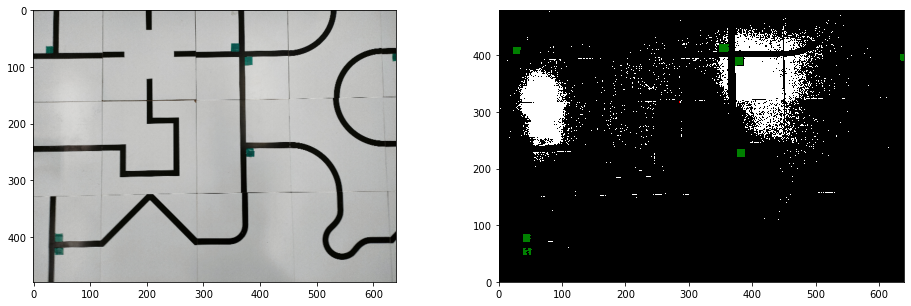

Color recognize model >>  LinearSVC()
Timer: 0.01795sec
Frame: 480px 640px


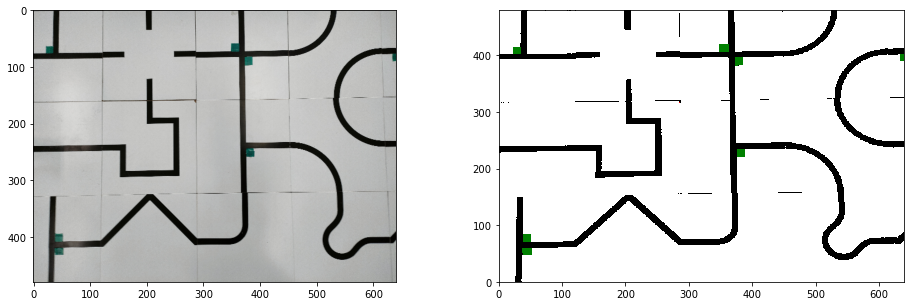

Color recognize model >>  GaussianNB()
Timer: 0.07781sec
Frame: 480px 640px


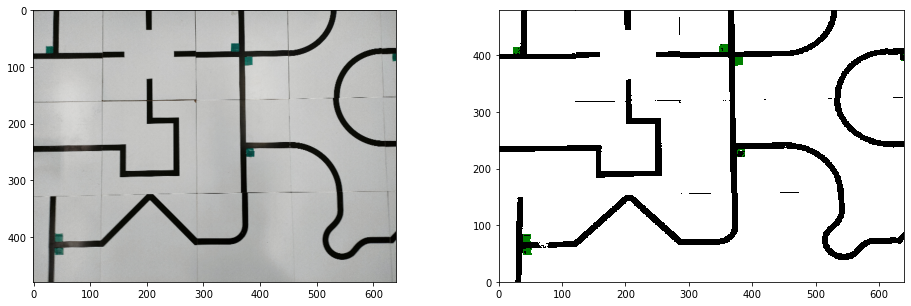

Color recognize model >>  MLPClassifier()
Timer: 0.25073sec
Frame: 480px 640px


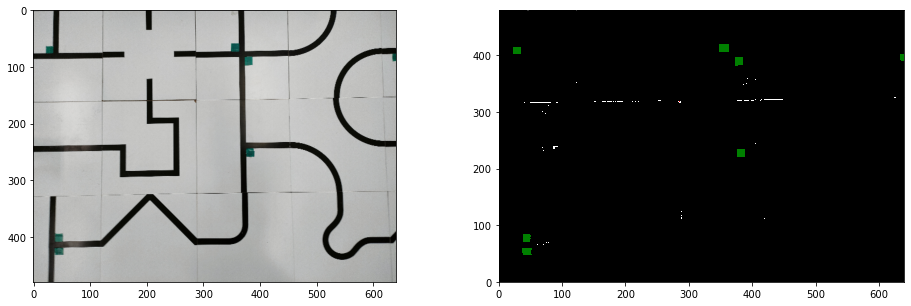

Color recognize model >>  KNeighborsClassifier()
Timer: 6.91486sec
Frame: 480px 640px


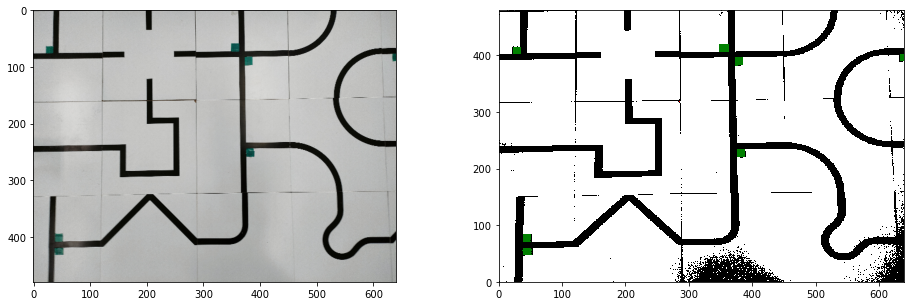

Color recognize model >>  DecisionTreeClassifier()
Timer: 0.03992sec
Frame: 480px 640px


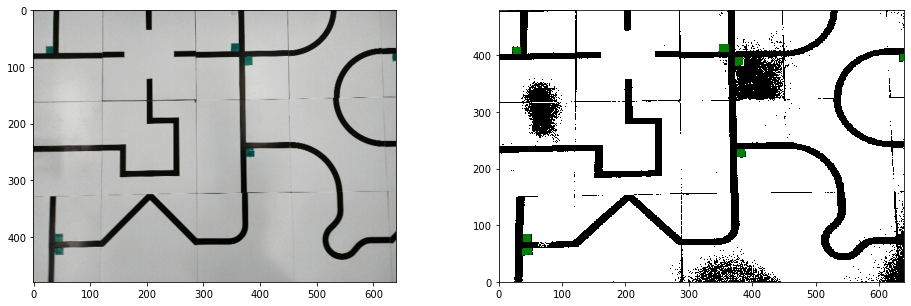

Color recognize model >>  AdaBoostClassifier()
Timer: 2.84096sec
Frame: 480px 640px


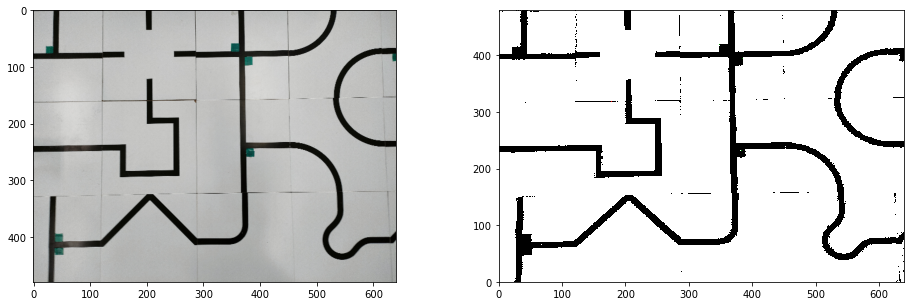

Color recognize model >>  RandomForestClassifier()
Timer: 4.49436sec
Frame: 480px 640px


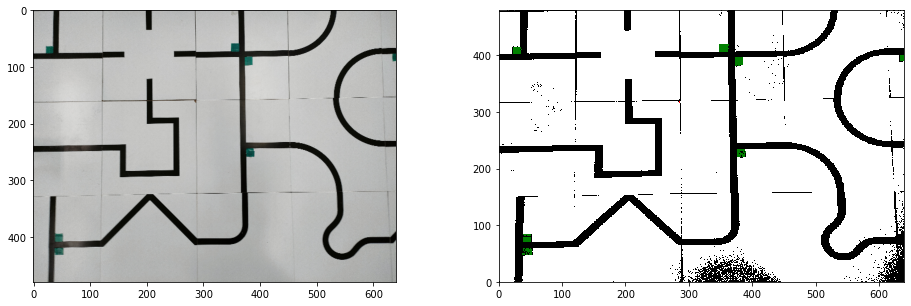

Color recognize model >>  QuadraticDiscriminantAnalysis()
Timer: 0.07480sec
Frame: 480px 640px


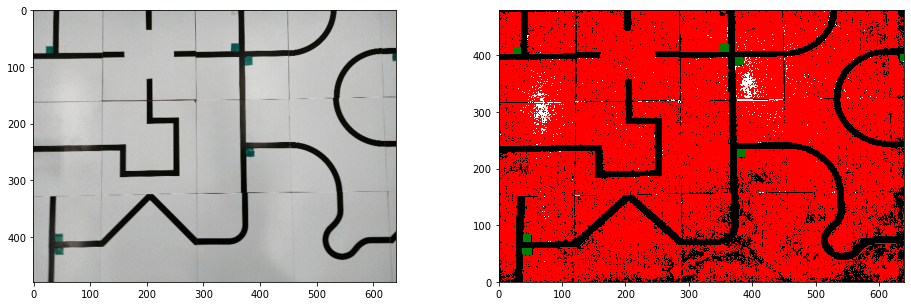

In [5]:
# 色識別モデル製作のための比較実験

from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

X_train, X_test, y_train, y_test = train_test_split(
    color_all[:, :-1],
    color_all[:, -1:],
    stratify=color_all[:, -1:],  # テストに使うデータを階層化する
    test_size=0.8,  # テストに使う割合
)

m_SVC = SVC().fit(X_train, y_train)
m_LinearSVC = LinearSVC().fit(X_train, y_train)
m_GaussianNB = GaussianNB().fit(X_train, y_train)
m_MLPClassifier = MLPClassifier().fit(X_train, y_train)
m_KNeighborsClassifier = KNeighborsClassifier().fit(X_train, y_train)
m_DecisionTreeClassifier = DecisionTreeClassifier().fit(X_train, y_train)
m_AdaBoostClassifier = AdaBoostClassifier().fit(X_train, y_train)
m_RandomForestClassifier = RandomForestClassifier().fit(X_train, y_train)
m_QuadraticDiscriminantAnalysis = QuadraticDiscriminantAnalysis().fit(X_train, y_train)


def prof():
    for _ in tqdm(range(10)):
        m_SVC.predict(X_test)
        m_LinearSVC.predict(X_test)
        m_GaussianNB.predict(X_test)
        m_MLPClassifier.predict(X_test)
        m_KNeighborsClassifier.predict(X_test)
        m_DecisionTreeClassifier.predict(X_test)
        m_AdaBoostClassifier.predict(X_test)
        m_RandomForestClassifier.predict(X_test)
        m_QuadraticDiscriminantAnalysis.predict(X_test)


pr = LineProfiler()
pr.add_function(prof)
pr.runcall(prof)
pr.print_stats()

# カラーパレットを用意する
colors = ["black", "green", "white", "red"]
cmap = ListedColormap(colors, name="custom")
for col_model in [m_SVC, m_LinearSVC, m_GaussianNB, m_MLPClassifier, m_KNeighborsClassifier, m_DecisionTreeClassifier, m_AdaBoostClassifier, m_RandomForestClassifier, m_QuadraticDiscriminantAnalysis]:
    print("Color recognize model >> ", col_model)

    # 写真を読み込む
    entire_img = cv2.imread(samples.imgs_entire[0])
    entire_img = cv2.resize(entire_img,(640, 480))
    entire_height, entire_width = entire_img.shape[:2]

    # 色を識別する
    timer_begin = time()
    entire_img_result = [col_model.predict(row) for row in reversed(entire_img)]
    print("Timer: {:,.5f}sec\nFrame: {:,}px {:,}px".format(time() - timer_begin, entire_height, entire_width))

    # 表示用に調整する
    entire_img_result[0][0] = 1  # black
    entire_img_result[0][1] = 2  # green
    entire_img_result[0][2] = 3  # white
    entire_img_result[0][3] = 4  # red

    # 表示
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(entire_img, cv2.COLOR_BGR2RGB))  # -> 注意
    plt.subplot(122)
    plt.pcolormesh(entire_img_result, cmap=cmap)
    plt.show()


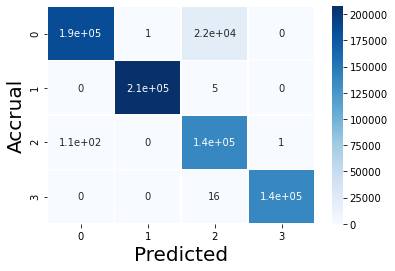

              precision    recall  f1-score   support

           1       1.00      0.89      0.94    207360
           2       1.00      1.00      1.00    207360
           3       0.86      1.00      0.93    138240
           4       1.00      1.00      1.00    138240

    accuracy                           0.97    691200
   macro avg       0.97      0.97      0.97    691200
weighted avg       0.97      0.97      0.97    691200



In [ ]:
# color recognizing model

X_train, X_test, y_train, y_test = train_test_split(
    color_all[:, :-1],
    color_all[:, -1:],
    stratify=color_all[:, -1:],  # テストに使うデータを階層化する
    test_size=0.3,  # テストに使う割合
)

col_model = LinearSVC().fit(X_train, y_train)

y_pred = col_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues', linewidth=0.3)
ax.set_xlabel("Predicted", fontsize=20)
ax.set_ylabel("Accrual", fontsize=20)
plt.show()

print(classification_report(y_test, y_pred))


Color recognize model >>  LinearSVC()
Timer: 0.38496sec
Frame: 3,468px 4,624px


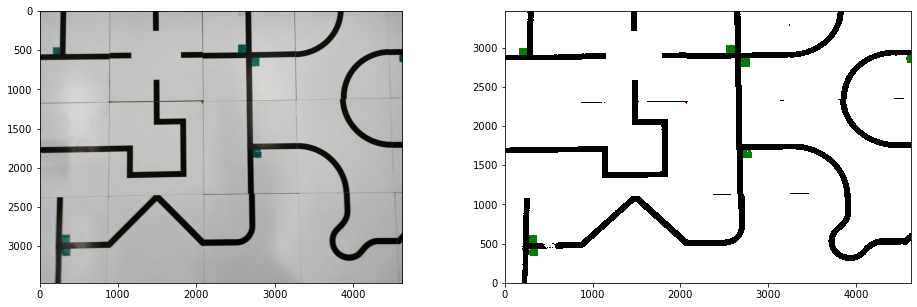

Timer: 0.38701sec
Frame: 3,468px 4,624px


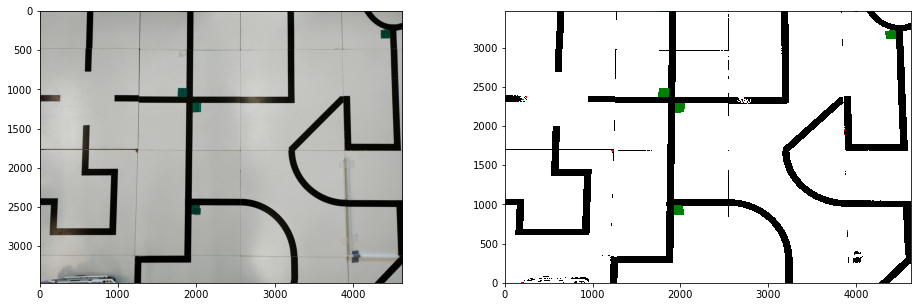

In [ ]:
# color recognizing model test
""" 注意
https://teratail.com/questions/114307

OpenCVはBGR順、matplotlibはRGB順を前提として扱います。
cv2.cvtColor(img, cv2.COLOR_BGR2RGB)にてRGB順に並べ替えることでmatplotlibでも正しい色で表示できるようになります。
"""
print("Color recognize model >> ", col_model)
for path in samples.imgs_entire:
    # カラーパレットを用意する
    from matplotlib.colors import ListedColormap
    colors = ["black", "green", "white", "red"]
    cmap = ListedColormap(colors, name="custom")

    # 写真を読み込む
    entire_img = cv2.imread(path)
    entire_height, entire_width = entire_img.shape[:2]

    # 色を識別する
    timer_begin = time()
    entire_img_result = [col_model.predict(row) for row in reversed(entire_img)]
    print("Timer: {:,.5f}sec\nFrame: {:,}px {:,}px".format(time() - timer_begin, entire_height, entire_width))

    # 表示用に調整する
    entire_img_result[0][0] = 1  # black
    entire_img_result[0][1] = 2  # green
    entire_img_result[0][2] = 3  # white
    entire_img_result[0][3] = 4  # red

    # 表示
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(entire_img, cv2.COLOR_BGR2RGB))  # -> 注意
    plt.subplot(122)
    plt.pcolormesh(entire_img_result, cmap=cmap)
    plt.show()
